In [119]:
# PART 1 - DATA PREPROCESSING
# Differentially expressed genes under exposure to PM2.5
# Source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158954

import pandas as pd
from scipy.stats import ttest_ind

# Loads the gene expression data
gene_expr = pd.read_csv("Gene Expression Data/GSE158954_series_matrix.txt", sep="\t", comment="!", index_col=0)
gene_expr = gene_expr.dropna()

# Defines control and PM2.5-exposed sample IDs
control_samples = ["GSM4816385", "GSM4816386", "GSM4816387"]
exposed_samples = ["GSM4816388", "GSM4816389", "GSM4816390"]

# Creates subset to relevant columns and clean
expr_data = gene_expr[control_samples + exposed_samples]
expr_data = expr_data.apply(pd.to_numeric, errors='coerce').dropna()

# Optional line limit to top N genes to speed up processing; uncomment to limit the number of lines
# expr_data = expr_data.head(N)

# Runs t-tests to find the differentially expressed genes
results = []
for gene in expr_data.index:
    control_vals = expr_data.loc[gene, control_samples]
    exposed_vals = expr_data.loc[gene, exposed_samples]
    t_stat, p_val = ttest_ind(control_vals, exposed_vals, equal_var=False)
    mean_diff = exposed_vals.mean() - control_vals.mean()
    results.append((gene, mean_diff, p_val))

# Creates a DataFrame with the results
diff_expr_df = pd.DataFrame(results, columns=["Gene", "MeanDifference", "PValue"])
diff_expr_df["Significant"] = diff_expr_df["PValue"] < 0.05
diff_expr_df = diff_expr_df.sort_values("PValue")

# Save the data to a csv file
diff_expr_df.to_csv("differential_expression_results.csv", index=False)

# Processing file was successful
print(f"Differential expression analysis complete. {diff_expr_df['Significant'].sum()} genes found significantly differentially expressed.")


/Users/andrewbae/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/andrewbae/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Differential expression analysis complete. 4152 genes found significantly differentially expressed.


In [115]:
# Differentially methylated CpG sites from lung cancer tissue
# Source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75008

# Loads the methylation data
with open("DNA Methylation Data/GSE75008_series_matrix.txt", "r") as f:
    lines = f.readlines()

# Extracts the sample metadata
sample_geo_ids = []
sample_titles = []
sample_types = []

for line in lines:
    if line.startswith("!Sample_geo_accession"):
        sample_geo_ids = [x.strip('"') for x in line.strip().split("\t")[1:]]
    elif line.startswith("!Sample_title"):
        sample_titles = line.strip().split("\t")[1:]
    elif line.startswith("!Sample_characteristics_ch1"):
        sample_types = [x.split(": ")[1] if ": " in x else x for x in line.strip().split("\t")[1:]]
    elif line.startswith("!series_matrix_table_begin"):
        break

# Parses the methylation table
start_idx = lines.index("!series_matrix_table_begin\n") + 1
end_idx = lines.index("!series_matrix_table_end\n")

from io import StringIO
methylation_df = pd.read_csv(StringIO("".join(lines[start_idx:end_idx])), sep="\t", index_col=0)

# Matches the sample types to GEO IDs
sample_info = pd.DataFrame({
    "geo_id": sample_geo_ids,
    "title": sample_titles,
    "type": sample_types
})
sample_info.set_index("geo_id", inplace=True)

# Identifies the different groups
tumor_ids = sample_info[sample_info["type"].str.lower().str.contains("lung cancer")].index
control_ids = sample_info[sample_info["type"].str.lower().str.contains("normal lung")].index

tumor_data = methylation_df[tumor_ids]
control_data = methylation_df[control_ids]

# Carries out a t-test per CpG site
p_values = []
delta_means = []

for probe in methylation_df.index:
    t_stat, p_val = ttest_ind(tumor_data.loc[probe].dropna(), control_data.loc[probe].dropna(), equal_var=False)
    delta = tumor_data.loc[probe].mean() - control_data.loc[probe].mean()
    p_values.append(p_val)
    delta_means.append(delta)

# Adds the stats to the DataFrame
results = pd.DataFrame({
    "CpG_site": methylation_df.index,
    "p_value": p_values,
    "delta_methylation": delta_means
}).set_index("CpG_site")

# Applies a significance threshold (95% confidence level)
results["significant"] = results["p_value"] < 0.05

# Sorts by most differentially methylated
results_sorted = results.sort_values(by="p_value")

# Saves the results to a csv file
results_sorted.to_csv("differential_methylation_results.csv")

# Processing file was successful
print(f"Differential methylation analysis complete. {results_sorted['significant'].sum()} CpG sites found significant.")

# Note: this step takes a while due to the size of the dataset, but it goes through


Differential methylation analysis complete. 292289 CpG sites found significant.


In [116]:
# PART 2 - ANALYZING DATASETS TO EXTRACT REFERENCE SEQUENCES

# Loads the results for differential expression and methylation
expr_df = pd.read_csv("differential_expression_results.csv")
meth_df = pd.read_csv("differential_methylation_results.csv")

# Loads the Expression Platform Manifest file
gpl_df = pd.read_csv("GPL570-55999.csv", skiprows=16)  # Update with your actual filename
# Columns: ID, RefSeq Transcript ID
gpl_df = gpl_df[["ID", "RefSeq Transcript ID"]].dropna()
gpl_df["RefSeq Transcript ID"] = gpl_df["RefSeq Transcript ID"].astype(str)
gpl_df = gpl_df.assign(RefSeqs=gpl_df["RefSeq Transcript ID"].str.split(";")).explode("RefSeqs")
gpl_df["RefSeqs"] = gpl_df["RefSeqs"].str.strip().str.upper()

# Maps the differentially expressed probe IDs to RefSeq transcript IDs
expr_df["Gene"] = expr_df["Gene"].astype(str).str.strip()
sig_expr_df = expr_df[expr_df["Significant"] == True]
expr_mapped = sig_expr_df.merge(gpl_df, left_on="Gene", right_on="ID", how="left")
expr_mapped = expr_mapped.dropna(subset=["RefSeqs"])
expr_mapped["RefSeqs"] = expr_mapped["RefSeqs"].astype(str).str.strip().str.upper()


# Loads the Illumina HumanMethylation450 Manifest file
illumina_df = pd.read_csv("humanmethylation450_15017482_v1-2.csv", skiprows=7)  # Adjust skiprows if needed
illumina_df = illumina_df[["IlmnID", "UCSC_RefGene_Accession"]].dropna()
illumina_df = illumina_df.assign(RefSeqs=illumina_df["UCSC_RefGene_Accession"].str.split(";")).explode("RefSeqs")
illumina_df["RefSeqs"] = illumina_df["RefSeqs"].str.strip().str.upper()

# Maps the methylation CpG sites to RefSeq transcript IDs
meth_df["CpG_site"] = meth_df["CpG_site"].astype(str).str.strip()
meth_mapped = meth_df.merge(illumina_df, left_on="CpG_site", right_on="IlmnID", how="left")
meth_mapped = meth_mapped.dropna(subset=["RefSeqs"])
meth_mapped["RefSeqs"] = meth_mapped["RefSeqs"].astype(str).str.strip().str.upper()


/var/folders/z5/rnstt22j0nbb64vp9plyrsl80000gn/T/ipykernel_27896/3759325309.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  gpl_df = pd.read_csv("GPL570-55999.csv", skiprows=16)  # Update with your actual filename
/var/folders/z5/rnstt22j0nbb64vp9plyrsl80000gn/T/ipykernel_27896/3759325309.py:24: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  illumina_df = pd.read_csv("humanmethylation450_15017482_v1-2.csv", skiprows=7)  # Adjust skiprows if needed


In [100]:
# PART 3 - DETERMINING OVERLAY BETWEEN REFERENCE SEQUENCES

# Extracts the unique RefSeqs from both of the datasets
expr_refseqs = set(expr_mapped["RefSeqs"].dropna().unique())
meth_refseqs = set(meth_mapped["RefSeqs"].dropna().unique())

# Finds overlap between the two RefSeq datasets
overlapping_refseqs = expr_refseqs & meth_refseqs

# Filters the expression-mapped DataFrame for overlapping RefSeqs
overlapping_genes_df = expr_mapped[expr_mapped["RefSeqs"].isin(overlapping_refseqs)]

# Ensures uniqueness by dropping duplicates
unique_genes = overlapping_genes_df[["Gene", "RefSeqs"]].drop_duplicates()

# Prints the results
print(f"Number of overlapping RefSeqs: {len(overlapping_refseqs)}")
print("Corresponding Gene Names from expression data:")
for _, row in unique_genes.iterrows():
    print(f"{row['Gene']} ({row['RefSeqs']})")


Number of overlapping RefSeqs: 602
Corresponding Gene Names from expression data:
206307_s_at (NM_004472)
233340_at (NM_001040129)
211708_s_at (NM_005063)
204794_at (NM_004418)
207826_s_at (NM_002167)
207174_at (NM_004466)
231778_at (NM_005220)
224612_s_at (NM_025219)
1554539_a_at (NM_019034)
41469_at (NM_002638)
205287_s_at (NM_003222)
230922_x_at (NM_023934)
37408_at (NM_006039)
205767_at (NM_001432)
235496_at (NM_001039792)
211162_x_at (NM_005063)
226568_at (NM_001010883)
204932_at (NM_002546)
227799_at (NM_033054)
204580_at (NM_002426)
1562319_at (NM_182562)
205239_at (NM_001657)
204952_at (NM_014400)
200766_at (NM_001909)
201361_at (NM_024092)
208046_at (NM_003538)
200831_s_at (NM_005063)
225380_at (NM_138370)
1553698_a_at (NM_145257)
211538_s_at (NM_021979)
200748_s_at (NM_002032)
217456_x_at (NM_005516)
208215_x_at (NM_000797)
216020_at (NM_022168)
229461_x_at (NM_173808)
204465_s_at (NM_032727)
203665_at (NM_002133)
227048_at (NM_005559)
200905_x_at (NM_005516)
203439_s_at (NM_

Test set accuracy: 0.9834
5-fold cross-validated accuracy: 0.8559


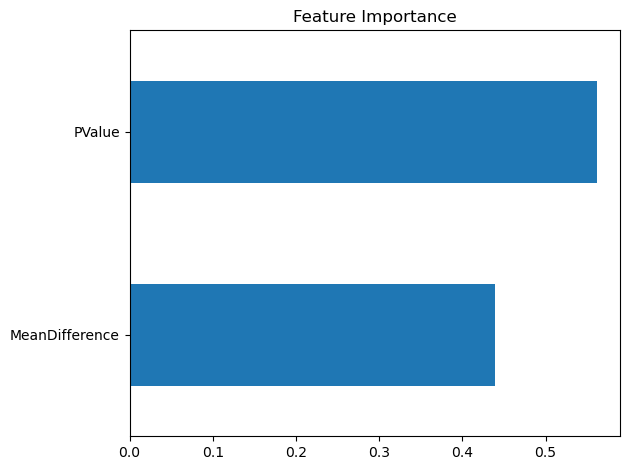

In [117]:
# PART 4 - MACHINE LEARNING GENE PREDICTION

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Loads the differential expression results
expr_df = pd.read_csv("differential_expression_results.csv")
expr_df["Gene"] = expr_df["Gene"].astype(str).str.strip()

# Prepare label: marks if a gene is in shared with methylation and therefore in unique_genes
unique_genes["Gene"] = unique_genes["Gene"].astype(str).str.strip()
expr_df["Shared"] = expr_df["Gene"].isin(unique_genes["Gene"]).astype(int)

# Drops the rows with missing values in the important columns (MeanDifference and PValue)
expr_df = expr_df.dropna(subset=["MeanDifference", "PValue"])

# Features and target
X = expr_df[["MeanDifference", "PValue"]]
y = expr_df["Shared"]

# Standardizes the features via StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Trains the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluates the model
accuracy = clf.score(X_test, y_test)
cross_val = cross_val_score(clf, X_scaled, y, cv=5)

print(f"Test set accuracy: {accuracy:.4f}")
print(f"5-fold cross-validated accuracy: {cross_val.mean():.4f}")

# Plots the importance of each feature (MeanDifference vs. PValue)
feat_importance = pd.Series(clf.feature_importances_, index=["MeanDifference", "PValue"])
feat_importance.sort_values().plot(kind="barh", title="Feature Importance")
plt.tight_layout()
plt.show()


In [112]:
# PART 5 - PREDICTION ON REAL PM2.5 DATA
# Preprocesses the air quality data

# Loads the daily PM2.5 data
pm25_df = pd.read_csv("Air Quality/daily_88101_2022.csv", low_memory=False)
pm25_df = pm25_df.rename(columns=str.strip)
pm25_df["Date Local"] = pd.to_datetime(pm25_df["Date Local"])
pm25_daily = pm25_df.groupby("Date Local")["Arithmetic Mean"].mean().reset_index()
pm25_daily.columns = ["Date", "PM25"]

# Loads the daily NO2 data
no2_df = pd.read_csv("Air Quality/daily_42602_2022.csv", low_memory=False)
no2_df = no2_df.rename(columns=str.strip)
no2_df["Date Local"] = pd.to_datetime(no2_df["Date Local"])
no2_daily = no2_df.groupby("Date Local")["Arithmetic Mean"].mean().reset_index()
no2_daily.columns = ["Date", "NO2"]

# Merge the data based on date
pollution_daily = pd.merge(pm25_daily, no2_daily, on="Date", how="inner")

# Previews and saves the data
print("Daily pollution data (no location):")
print(pollution_daily.head())

pollution_daily.to_csv("daily_pollution_averages.csv", index=False)


Daily pollution data (no location):
        Date      PM25        NO2
0 2022-01-01  8.100902   6.093624
1 2022-01-02  5.663169   7.810028
2 2022-01-03  6.497980  11.392146
3 2022-01-04  7.894422  11.935803
4 2022-01-05  7.969597  12.200920


In [118]:
# Uses a Random Forest classifier to predict days when pollution levels are likely activate genes linked to respiratory genes

import numpy as np

# Loads the preprocessed daily pollution data
pollution_daily = pd.read_csv("daily_pollution_averages.csv")
pollution_daily = pollution_daily.dropna(subset=["PM25", "NO2"])

# Loads the differential expression results
expr_df = pd.read_csv("differential_expression_results.csv")
expr_df["Gene"] = expr_df["Gene"].astype(str).str.strip()
unique_genes["Gene"] = unique_genes["Gene"].astype(str).str.strip()

# Label genes: 1 if gene is in both the methylation and expression datasets, 0 otherwise
expr_df["Label"] = expr_df["Gene"].isin(unique_genes["Gene"]).astype(int)

# Simulates PM2.5 and NO2 values per gene based on expression magnitude
np.random.seed(42)
expr_df["PM25"] = np.abs(expr_df["MeanDifference"] + np.random.normal(0, 1.5, size=len(expr_df)))
expr_df["NO2"] = np.abs(expr_df["MeanDifference"] + np.random.normal(0, 1.0, size=len(expr_df)))

# Prepares features and labels
X = expr_df[["PM25", "NO2"]]
y = expr_df["Label"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trains the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf, X_scaled, y, cv=5)
clf.fit(X_scaled, y)

print(f"Cross-validated mean accuracy: {scores.mean():.3f}")

# Predicts on the given real pollution data
pollution_scaled = scaler.transform(pollution_daily[["PM25", "NO2"]])
pollution_daily["HighRiskPrediction"] = clf.predict(pollution_scaled)
pollution_daily["PredictedProb"] = clf.predict_proba(pollution_scaled)[:, 1]

# Summary and preview of high-risk predictions
print(f"✅ Predicted {pollution_daily['HighRiskPrediction'].sum()} high-risk days out of {len(pollution_daily)}")
print(pollution_daily.head())

# === Save predictions ===
pollution_daily.to_csv("pollution_prediction_results.csv", index=False)

Cross-validated mean accuracy: 0.987
✅ Predicted 0 high-risk days out of 365
         Date      PM25        NO2  HighRiskPrediction  PredictedProb
0  2022-01-01  8.100902   6.093624                   0           0.11
1  2022-01-02  5.663169   7.810028                   0           0.21
2  2022-01-03  6.497980  11.392146                   0           0.11
3  2022-01-04  7.894422  11.935803                   0           0.11
4  2022-01-05  7.969597  12.200920                   0           0.11


/var/folders/z5/rnstt22j0nbb64vp9plyrsl80000gn/T/ipykernel_27896/457873431.py:20: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/Users/andrewbae/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


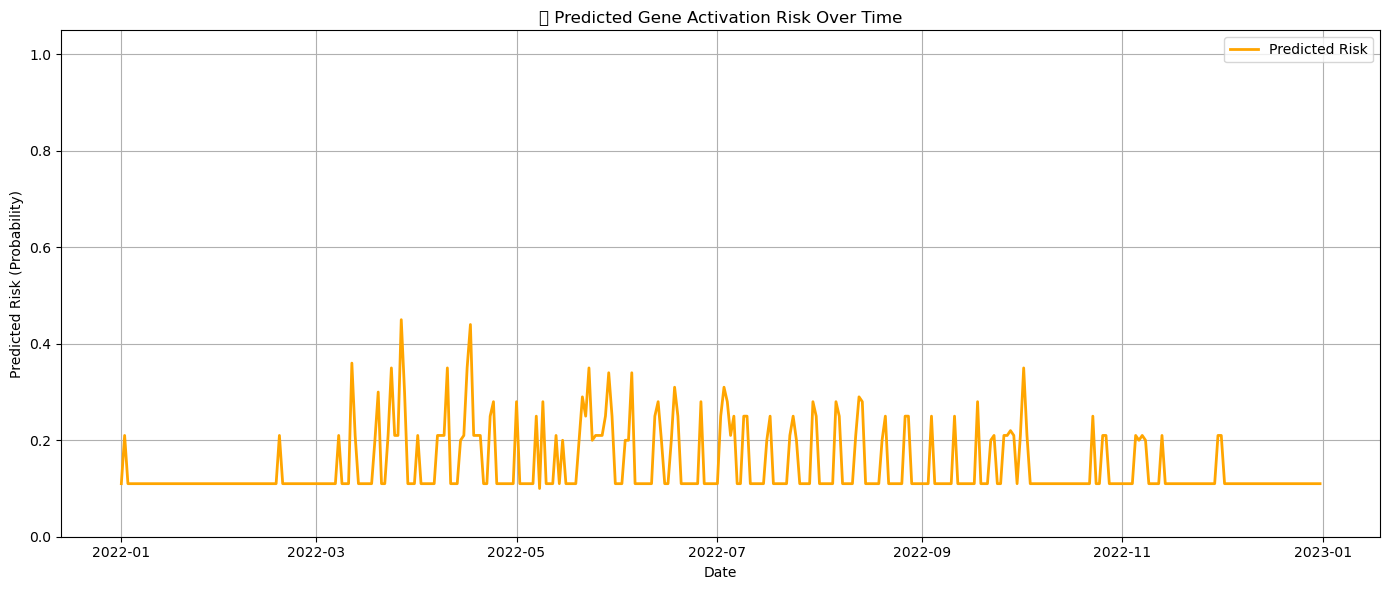

In [107]:
# Visualizes the risk factor of each day in the sample dataset

# Ensures each date is in datetime format
pollution_daily["Date"] = pd.to_datetime(pollution_daily["Date"])

# Plots the predicted probability of high-risk gene activation
plt.figure(figsize=(14, 6))
sns.lineplot(data=pollution_daily, x="Date", y="PredictedProb", label="Predicted Risk", color="orange", linewidth=2)

# Optional: highlights the threshold-crossing days
high_risk_days = pollution_daily[pollution_daily["HighRiskPrediction"] == 1]
sns.scatterplot(data=high_risk_days, x="Date", y="PredictedProb", color="red", s=50, label="High-Risk Prediction")

plt.title("🔥 Predicted Gene Activation Risk Over Time")
plt.xlabel("Date")
plt.ylabel("Predicted Risk (Probability)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
